In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

# Data Loading

In [2]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset/"):
    if sub_folder[0] == ".":
        continue

    sub_folder_files = os.listdir(os.path.join("dataset/", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset/", sub_folder, filename)

        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)

# Data Preparation

## Define Preprocessing Function

In [3]:
def resize(image, target_size):
    result = np.zeros(target_size, image.dtype)
    step = (image.shape[0] // target_size[0], image.shape[1] // target_size[1])
    result = image[0::step[0], 0::step[1]]
    return result

# Ekualisasi Histogram
def prepro1():
    pass

# Perbaikan Citra - Filter Median
def prepro2(img, size=(3, 3)):
    result = np.zeros(img.shape, img.dtype)

    half_kern_size = (size[0]//2 ,size[1]//2)
    padded = np.pad(img, pad_width=half_kern_size, mode="edge")
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            temp = np.sort(padded[y:y+size[0], x:x+size[1]].flatten())[(size[0] * size[1]) // 2]
            result[y,x] = temp

    return result

# Deteksi Tepi - Metode Robert
def prepro3(img):
    kernel = np.array([
        [
            [1, 0],
            [0,  -1]
        ],
        [
            [0, 1],
            [-1, 0]
        ]
    ])

    result = np.zeros(img.shape, dtype=img.dtype)

    padded = np.zeros((img.shape[0] + 1, img.shape[1] + 1), dtype=img.dtype)
    padded[1:, 1:] = img[:, :]

    for y in range(result.shape[0]):
        for x in range(result.shape[1]):
            sx = np.sum(padded[y:y+kernel[0].shape[0], x:x+kernel[0].shape[1]] * kernel[0])
            sy = np.sum(padded[y:y+kernel[0].shape[1], x:x+kernel[0].shape[1]] * kernel[1])

            result[y, x] = np.sqrt(sx**2 + sy**2)

    return result

# Deteksi Tepi - Metode Sobel
def prepro4(img):
    kernel = np.array([
        [
            [-1, 0, 1],
            [-2, 0, 2],
            [-1, 0, 1]
        ],
        [
            [1, 2, 1],
            [0, 0, 0],
            [-1, -2, -1]
        ]
    ])

    result = np.zeros(img.shape, dtype=img.dtype)

    padded = np.zeros((img.shape[0] + 2, img.shape[1] + 2), dtype=img.dtype)
    padded[2:, 2:] = img[:, :]

    for y in range(result.shape[0]):
        for x in range(result.shape[1]):
            sx = np.sum(padded[y:y+kernel[0].shape[0], x:x+kernel[0].shape[1]] * kernel[0])
            sy = np.sum(padded[y:y+kernel[0].shape[1], x:x+kernel[0].shape[1]] * kernel[1])

            result[y, x] = np.sqrt(sx**2 + sy**2)

    return result

## Preprocessing

In [4]:
dataPreprocessed = []
for i in range(len(data)):
    img = prepro2(data[i])
    img = prepro3(img)
    dataPreprocessed.append(img)

## Feature Extraction

In [5]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [6]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [7]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [8]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [9]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [10]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [11]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [12]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [13]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [14]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [15]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [16]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [17]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [18]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [19]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [20]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [21]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

## Write the extraction's results to CSV

In [22]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,Training_318555.jpg,fear,1437.307181,2037.628791,702.994238,1922.406066,0.214927,0.178172,0.267619,0.203177,...,0.004895,0.003274,0.059678,0.053787,0.069965,0.057215,0.476754,0.157280,0.767477,0.205218
1,Training_266022.jpg,fear,1670.002216,2216.168402,826.808954,1809.771390,0.123199,0.084898,0.148552,0.108645,...,0.001046,0.000782,0.028965,0.026223,0.032349,0.027966,0.352762,0.120139,0.690150,0.281867
2,Training_663754.jpg,fear,1130.755762,1213.871888,745.589982,1269.291535,0.201178,0.146876,0.196794,0.155008,...,0.002277,0.001880,0.048637,0.042189,0.047714,0.043355,0.487394,0.390127,0.669079,0.360352
3,Training_1791051.jpg,fear,926.434397,1318.512449,621.960106,1291.535084,0.257057,0.223658,0.302682,0.237883,...,0.007454,0.005323,0.077678,0.069437,0.086337,0.072959,0.492961,0.206577,0.697614,0.225447
4,Training_1077665.jpg,fear,1100.643617,1764.273880,1198.986702,1955.591218,0.191326,0.157175,0.212995,0.164176,...,0.003050,0.002383,0.053707,0.048006,0.055226,0.048812,0.573219,0.213733,0.495415,0.124411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,Training_2269690.jpg,angry,474.937943,829.334993,606.273050,946.417383,0.182873,0.124154,0.172001,0.122755,...,0.001737,0.001322,0.041259,0.035857,0.041678,0.036352,0.675086,0.337382,0.561190,0.244468
696,Training_2724105.jpg,angry,538.630762,794.363966,523.871897,878.892712,0.175858,0.148055,0.215843,0.172647,...,0.002836,0.002203,0.048649,0.045123,0.053257,0.046940,0.670550,0.438950,0.658173,0.384304
697,Training_1559786.jpg,angry,742.798759,1166.701675,596.058954,1118.852422,0.209965,0.169578,0.226616,0.181467,...,0.003169,0.002458,0.053306,0.047904,0.056290,0.049578,0.575782,0.293410,0.653767,0.326464
698,Training_211850.jpg,angry,397.757979,559.320960,265.625887,615.677230,0.252315,0.223727,0.290048,0.226289,...,0.005248,0.003795,0.066528,0.062519,0.072441,0.061607,0.561626,0.276019,0.653524,0.208764


## Features Selection

<Axes: >

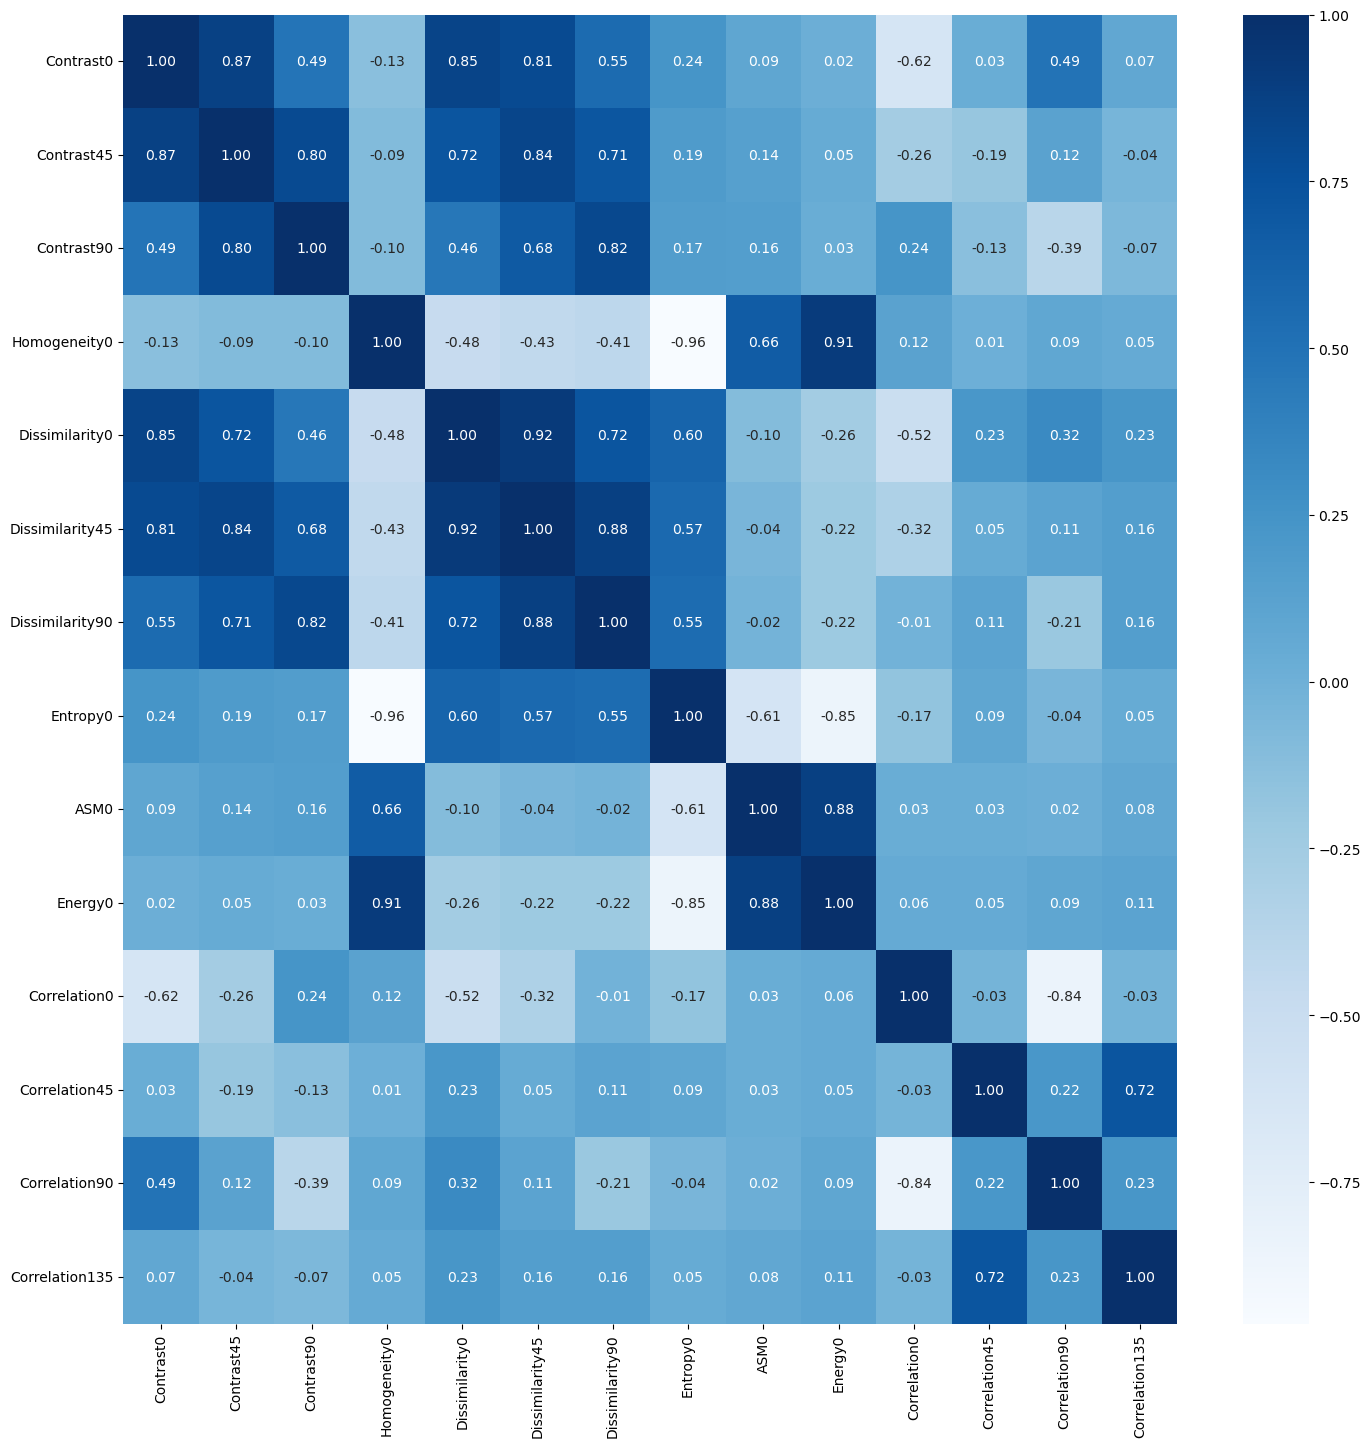

In [23]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [24]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(560, 14)
(140, 14)


## Feature Normalization

In [25]:
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

# Modelling

## Define Modelling

In [26]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

## Train Random Forest Classifier

In [27]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

       angry       0.82      0.94      0.87        80
     disgust       0.92      0.95      0.93        80
        fear       0.92      0.88      0.90        75
       happy       0.93      0.92      0.92        86
     neutral       0.95      0.95      0.95        79
         sad       0.95      0.88      0.91        82
    surprise       0.97      0.91      0.94        78

    accuracy                           0.92       560
   macro avg       0.92      0.92      0.92       560
weighted avg       0.92      0.92      0.92       560

[[75  0  1  0  0  3  1]
 [ 3 76  1  0  0  0  0]
 [ 4  3 66  1  1  0  0]
 [ 3  3  1 79  0  0  0]
 [ 1  0  2  0 75  0  1]
 [ 4  1  0  4  1 72  0]
 [ 2  0  1  1  2  1 71]]
Accuracy: 0.9178571428571428

------Testing Set------
              precision    recall  f1-score   support

       angry       0.15      0.25      0.19        20
     disgust       0.22      0.35      0.27   

## Tain SVM Classifier

In [28]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       angry       0.41      0.33      0.36        80
     disgust       0.29      0.28      0.28        80
        fear       0.36      0.36      0.36        75
       happy       0.28      0.49      0.35        86
     neutral       0.37      0.35      0.36        79
         sad       0.57      0.21      0.30        82
    surprise       0.27      0.31      0.29        78

    accuracy                           0.33       560
   macro avg       0.36      0.33      0.33       560
weighted avg       0.36      0.33      0.33       560

[[26 11  4 18  7  4 10]
 [ 6 22  8 25  7  0 12]
 [ 7  6 27 16  8  1 10]
 [ 9 10  6 42  8  3  8]
 [ 5  6  9 19 28  2 10]
 [ 3 10  8 18 12 17 14]
 [ 8 11 13 14  5  3 24]]
Accuracy: 0.33214285714285713

------Testing Set------
              precision    recall  f1-score   support

       angry       0.07      0.05      0.06        20
     disgust       0.22      0.20      0.21 

## Train KNN Classifier

In [29]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       angry       0.34      0.62      0.44        80
     disgust       0.48      0.57      0.52        80
        fear       0.43      0.41      0.42        75
       happy       0.48      0.45      0.46        86
     neutral       0.51      0.24      0.33        79
         sad       0.54      0.41      0.47        82
    surprise       0.41      0.33      0.37        78

    accuracy                           0.44       560
   macro avg       0.46      0.44      0.43       560
weighted avg       0.46      0.44      0.43       560

[[50  5  2  8  3  4  8]
 [11 46  5  7  2  3  6]
 [14 11 31  4  3  4  8]
 [21  7  7 39  4  5  3]
 [23 10  8  8 19  6  5]
 [15  7  9  7  3 34  7]
 [13 10 10  9  3  7 26]]
Accuracy: 0.4375

------Testing Set------
              precision    recall  f1-score   support

       angry       0.13      0.25      0.17        20
     disgust       0.19      0.20      0.20        20
   

## Evaluation With Confusion Matrix

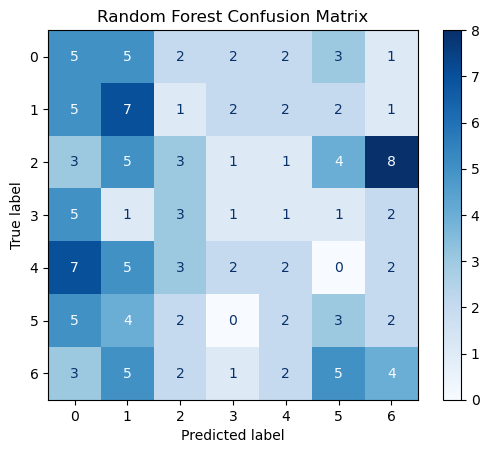

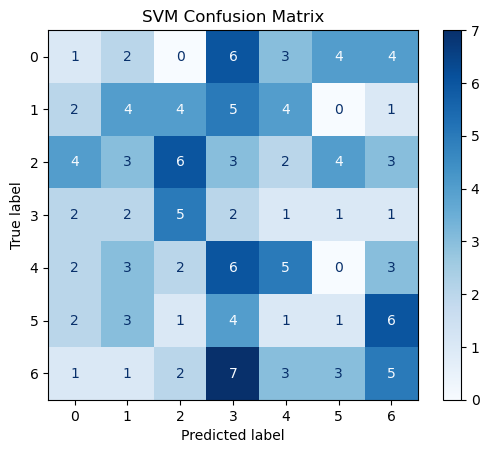

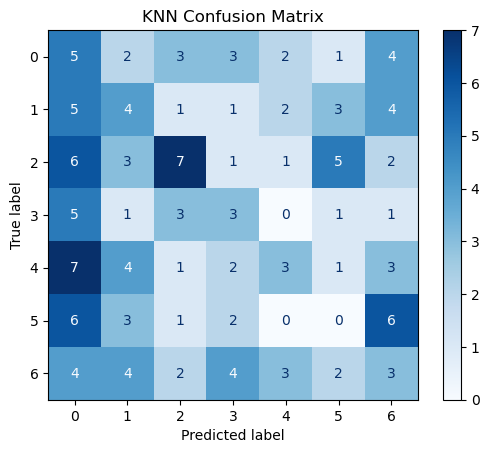

In [30]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")